# 3 - Neural Machine Translation by Jointly Learning to Align and Translate
120220107 강희주 

## Introduction
 하나의 큰 neural network를 이용한 translation 방법인 neural machine translation은 대부분 encoder-decoder 형식으로 이루어져 있다. 
 encoder의 경우, $$h_{t} = f(x_{t}, h_{t-1})$$ 위의 식과 같이 이전 time step t-1에서의 hidden state $h_{t-1}$와 해당 time step t에서의 입력 단어$x_{t}$를 통해 time step t에서의 hidden state $h_{t}$를 구한 후, 다음의 식과 같이 이렇게 구한 모든 hidden state들로 고정 길이 벡터c를 얻는다. $$c=q({h_{1}, ..., h_{T_{x}}})$$  
 이때 f(),q()는 non-linear function을 의미하며, 이렇게 구한 고정 길이 벡터 c는 context vector라고도 하며, 입력 문장의 전체적인 정보들을 담고 있다.  
 
 decoder에서는 위와 같이 구한 고정 길이 벡터 c와, 이전까지 예측한 단어들 {$y_{1},..., y_{t-1}$}이 주어졌을 때, 다음 단어인 $y_{t}$를 예측하도록 학습된다. 일단 번역이라는 task는 target sequence를 y라 하고, 번역하고자 하는 sequence를 x라고 했을 때, x가 주어졌을 때의 y에 대한 조건부 확률을 최대화 하는 것을 목적으로 한다. 즉, 디코더에서는 $argmax_{y}P(y_{t} | {y_{1}, .., y_{t-1}}, c)$ 를 만족시키는 $y_{t}$를 찾는다. 

 이런한 encoder-decoder 구조는 문장 길이가 짧을 때는 문제가 없지만, 고정 길이 벡터 c의 dimension 이 충분히 크지 않으면서 입력으로 들어온 문장의 길이가 길다면 전체 문장의 정보를 하나의 고정 길이 벡터 c에 함축할 수 없다는 문제가 발생한다.

 때문에 주어진 논문에서는 encoder-decoder 모델에서 새로운 구조를 추가해서 다음의 문제를 해결할 수 있는 방법을 제안한다. 기존의 encoder-decoder 모델에서는
 encoder에서 나온 모든 hidden state들을 활용하지 않고, 단순히 마지막에 나온 hidden state를 고정 길이 벡터 c로 정하였고, decoder에서는 이 벡터를 이용하여 번역 task를 수행하였다면, 주어진 논문에서는 encoder에서 나온 각각의 모든 RNN cell의 hidden state를 활용하여 decoder에서 dynamic하게 각 state 별로 context vector를 만들어 번역 task를 수행하면 앞서 말했던 문제를 해결할 수 있다고 제시하고 있다.    
 이 방법의 장점은 두 가지가 있다. 첫째로, 더 이상 context vector는 고정된 길이의 벡터가 아니라는 점이다. 두 번째는 decoder에서 target word를 예측할 때, encoder에서 나온 모든 hidden state 중에서 집중해야 할 단어들에게만 집중할 수 있는 매커니즘을 따로 설계할 수 있다는 점이다. 여기에 해당하는 것이 바로 해당 논문의 주 아이디어인 *attention* 이다. 

In [1]:
#Colab 사용을 위한 준비
#torchtext.legacy 사용을 위해 torchtext를 0.11.0으로 downgrade
!pip install torchtext==0.11.0
#영어, 독일어 spacy 모델을 다운로드
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 32.5 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x39e22000 @  0x7fb87f664615 0x58e046 0x4f2e5e 0x4d19df 0x51b31c 0x5b41c5 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51837f 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4ba70a 0x538136 0x590055 0x51b180 0x5b41c5 0x58f49e 0x51837f 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x517947 0x5b41c5 0x58f49e
     |████████████████████████████████| 881.9 MB 19 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does n

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

난수 생성기의 seed를 고정하면, 매번 프로그램을 실행할 때 마다 생성되는 난수들의 수열이 같게 할 수 있다. 이를 통해 반복 실행시, 결과가 재현되도록 해주었다. 

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

spacy는 파이썬의 자연어처리를 위한 오픈 소스 기반 라이브러리로 Tokeniztion(입력 텍스트를 단어, 문장 부호 등의 토큰으로 분류하는 과정), POS Tagging(문장 내 단어들의 품사를 식벼라여 태그를 붙여주는 과정), Dependency Parsing(각 token 들간의 의존관계를 고려하여 관련있는 단어들끼리 묶는 과정) 등의 기능을 제공한다. 독일어를 위한 spaCy 모델은 "de_core_news_sm"이고, 영어를 위한 모델은 "en_core_web_sm"이며 각 모델의 tokenizer에 접근하기 위해 해당 모델을 로드하였다. 


In [4]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

각 언어의 tokenizer를 생성한다. 생성한 함수의 입력으로 들어온 text는 spaCy model의 tokenizer에 입력되어 해당 문자열을 구성하는 개별 토큰으로 분류되며, 정의된 함수의 출력으로는 개별 토큰들로 이루어진 list를 얻게 된다.   

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

torchtext 에는 필드(field)라는 도구를 제공한다. 필드를 통해 앞으로 어떤 전처리를 할 것인지를 정의한다. SRC field 안에서는 tokenizer로 tokenize_de 함수(독일어 tokenizer)를 사용하며,init_token 과 eos_token 인수를 통해 sos(start of sequence) 와 eos(end of sequece) 토큰을 추가하고, 데이터를 모두 소문자로 바꾸겠다고 정의한다. TPG field 안에서는 tokenizer로 tokenize_en 함수(영어 tokenizer)를 사용하며, SRC field와 마찬가지로 sos 와 eos 토큰을 추가하고, 데이터를 모두 소문자로 바꾸겠다고 정의한다.  

In [6]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Multi30k dataset은 약 30,000 개의 영어, 독일어, 프랑스어로 이루어진 문장들이 포함되어 있으며, 한 문장당 대략 12개의 단어로 구성되어 있다. exts는 source와 target으로 사용될 언어를 지정하며(source가 첫번째), fields는 source와 target에서 사용될 전처리 도구인 field를 지정해준다. 
splits 함수를 통해 Multi30k dataset을 분할하여 train, validation, test data를 얻는다.   

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:01<00:00, 1.11MB/s]


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 278kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 275kB/s]


source 언어와 target 언어의 *vocabulary*를 생성한다. vocabulary는 각각의 고유한 토큰을 인덱스와 연결하는데 사용된다. source 와 target 언어의 vocabulary는 서로 구분된다. 
min_freq 인수를 사용하여 단어의 빈도 수가 2보다 작은 단어들은 처리하지 않는다. 다시 말해서 빈도 수가 최소 2보다 큰 단어들만 vocaburary에 추가하도록 최소 등장 빈도 조건을 추가하였다. 한번만 등장하는 단어들은 unknown token <unk>로 처리된다.
이때 우리 모델에서 정보 누출을 방지하기 위해 vocabulary는 오직 training set에서만 생성되어야 한다. 정보누출은 인위적으로 부풀려진 validation/test 점수를 제공하므로 방지되어야 한다.  

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

선언한 device는 GPU로 설정이 되었으며, GPU를 사용할 수 없는 경우 CPU를 사용한다. 

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BucketIterator를 생성한다. 이는 Pytorch의 dataloader와 쓰임새가 같다. 즉, 배치 크기 단위로 값을 차례대로 꺼내어 메모리로 가져오고 싶을 때 사용한다. 하지만 dataloader와는 다르게 비슷한 길이의 문장들끼리 batch를 만들기 때문에 padding의 개수를 최소화할 수 있다. 
자연어 처리를 하다보면 각 문장의 길이가 서로 다를 수 있는데, 병렬 연산을 위해서는 여러 문장의 길이를 임의로 동일하게 맞춰주는 작업이 필요할 때가 있다. 이때 데이터에 특정값을 채워서 데이터의 크기(shape)를 조정하는 것을 padding 이라고 한다.  

In [39]:
BATCH_SIZE = 128
#BATCH_SIZE=1

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model

### Encoder
기존의 encoder에서와 동일하게 input sequence $x = (x_{1},..., x_{T_{x}})$가 encoder의 입력으로 제공된다. 그러나 한 방향만으로 input을 읽는 RNN과 달리 입력 문장에 대해서 이전에 나타나는 내용과 함께, 이후에 나타나는 내용을 읽는 bidirectional RNN(BiRNN)을 사용한다. 

BiRNN은 두 개의 RNN(forward RNN, backward RNN)으로 구성되며, Forward RNN은 처음부터 순차적으로 입력을 읽어서 hidden state를 생성한다. 

Backward RNN은 입력의 제일 뒤에서부터 역방향으로 입력을 읽어서 역방향의 hidden state를 생성한다. 아래의 식과 같이 time step j 에서의 입력 $x_j$에 대해서 forward hidden state $h_T^\rightarrow$ 와 backward hidden state $h_T^\leftarrow$ 를 연결해서(concat) j번째 hidden state를 생성한다. $$h_{j}=[h_j^\rightarrow; h_j^\leftarrow]^{T}$$ 
인접한 state의 정보를 더 많이 가지고 있는 RNN의 특성상, $h_{j}$는 입력 단어 $x_{j}$의 양방향으로 더 가까운 위치에 있는 단어들의 정보를 더 많이 보유하게 된다. 


In [40]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        '''
        nn.Embedding()은 룩업 테이블 과정을 수행한다. 즉, 특정 토큰과 맵핑되는 정수(이는 vocabulary에서 지정됨)를 인덱스로 가지는 
        테이블(임베딩 테이블)로부터 임베딩 벡터 값을 가져온다. nn.Embedding()은 크게 두 가지 인자를 받는데, 각각 input_dim과 emb_dim 이다. 
        input_dim은 임베딩을 할 단어들의 개수로, 다시 말해 단어 집합의 크기이며, 임베딩 테이블은 인자로 받은 단어 집합의 크기만큼 행을 가진다. 
        emb_dim은 특정 토큰과 맵핑되는 정수를 인덱스로 가지는 벡터(즉, 임베딩 벡터)의 차원에 해당하며 , 이는 사용자가 정해주는 하이퍼파라미터이다. 
        '''
        self.embedding = nn.Embedding(input_dim, emb_dim)
        '''
        bidirectional = True로 설정하여 BiRNN을 구현한다. 
        첫번째 인자는 input size를 설정한다. RNN cell에는 임베딩 벡터가 입력되므로 이 벡터의 차원에 해당되는 값을 전달해준다.
        두번째 인자에는 hidden state의 dimension을 전달해준다. BiRNN은 두 개의 RNN으로 구성되는데, 하나의 RNN에서 생성되는 hidden state의 차원에 해당한다. 
        '''
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        '''
        BiRNN이므로 fc(fully-connected) layer는 순방향 RNN과 역방향 RNN의 hidden state를 concat한 결과의 size를 input의 크기로 받는다. 
        따라서 input의 size를 enc_hid_dim에 2를 곱해준 만큼의 크기로 설정하였다. 이는 후에 decoder의 초기 hidden state가 될 것이므로,
        nn.Linear 함수를 통해 decoder의 hidden state의 차원과 맞게끔 조절해준다. 
        '''
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        #dropout은 overfitting을 해결할 수 있는 방법 중 하나로, 일부 파라미터를 학습에 반영하지 않음으로써 모델을 일반화하는 방법이다. 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        #src 텐서값 출력 
        #print("src")
        #print("shape : ", src.shape)
        #print(src)

        #src = [src len, batch size]
        '''
        src 텐서를 input으로 받으며 이를 임베딩하고, dropout을 적용한다. 
        '''
        #임베딩된 텐서값 출력 
        embedded = self.embedding(src)
        #print("embedded before dropout")
        #print("shape : ", embedded.shape)
        #print(embedded)
        embedded = self.dropout(embedded)
        
        #드롭 아웃 이후 임베딩 텐서값 출력 
        #print("embedded after dropout")
        #print("shape : ", embedded.shape)
        #print(embedded)

        #embedded = [src len, batch size, emb dim]
        '''
        outputs과 hidden은 rnn의 출력값이다
        output은 GPU의 hidden state를 모아놓은 것으로 세번째 차원 [hid dim*num directions]에서 첫번쨰는 forward RNN, 두번째는 backward RNN을 의미한다.
        hidden은 마지막(t=src len) hidden state 값으로, [n layers*num_directions , batch size , hid dim] 차원이다.  

        '''
        outputs, hidden = self.rnn(embedded)
        #outputs 텐서와 hidden 텐서의 크기와 값 출력 
        #print("outputs")
        #print("shape : ", outputs.shape)
        #print(outputs)
        #print("hidden")
        #print("shape : ", hidden.shape)
        #print(hidden)        
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        '''
        순방향 hidden states와 역방향 hidden states를 concat을 하게 된다. 
        hidden[-2,:,:]은 forwards RNN을, hidden[-1,:,:]은 backward RNN을 의미한다. Batch는 변하면 안되므로 Batch 차원은 유지(dim=1)한다. 
        '''
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        #FC layer를 통과한 후의 hidden 텐서의 크기와 값 출력
        #print("hidden after FC layer")
        #print("shape : ", hidden.shape)
        #print(hidden)

        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### 임베딩된 텐서값

src
shape :  torch.Size([17, 1])
tensor([[   2],
        [   5],
        [  66],
        [  25],
        [ 443],
        [  23],
        [  22],
        [  14],
        [5620],
        [2165],
        [2408],
        [  10],
        [1910],
        [  23],
        [ 147],
        [   4],
        [   3]], device='cuda:0')

src 텐서의 크기는 (src len, batch size)이며, src len은 sequence length 와 같다. 즉, 해당 문자열의 토큰의 개수이다. src는 벡터값이 아닌 스칼라 값의 list라는 것을 확인할 수 있는데, 이는 특정 토큰과 맵핑되는 정수를 가져온 것이기 때문이다.  

### dropout 적용 전과 후의 임베딩된 텐서의 크기와 값
embedded before dropout
shape :  torch.Size([17, 1, 256])
tensor([[[ 0.0200,  0.0012,  0.0028,  ..., -0.0058, -0.0041, -0.0096]],

        [[-0.0053,  0.0009, -0.0111,  ...,  0.0094, -0.0088,  0.0010]],

        [[ 0.0132,  0.0101,  0.0139,  ...,  0.0018,  0.0006,  0.0002]],

        ...,

        [[-0.0118,  0.0077, -0.0036,  ...,  0.0030,  0.0109, -0.0012]],

        [[-0.0139,  0.0171,  0.0039,  ...,  0.0028,  0.0143, -0.0139]],

        [[ 0.0131,  0.0032, -0.0025,  ...,  0.0310,  0.0055, -0.0038]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
embedded after dropout
shape :  torch.Size([17, 1, 256])
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0083,  0.0000]],

        [[-0.0106,  0.0000, -0.0222,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0036,  0.0012,  0.0004]],

        ...,

        [[-0.0237,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0023]],

        [[-0.0278,  0.0000,  0.0000,  ...,  0.0000,  0.0286,  0.0000]],

        [[ 0.0000,  0.0065,  0.0000,  ...,  0.0620,  0.0000,  0.0000]]],
       device='cuda:0', grad_fn=<FusedDropoutBackward0>)


임베딩된 텐서의 크기는 (src len, batch size, emb dim)임을 확인할 수 있다. 
batch size와 emb dim은 각각 1과 256으로 설정해주었고, 입력된 문자열의 토큰의 개수가 12이기 때문에 src len이 12로 나왔다. 
이를 통해, 특정 토큰과 맵핑되는 정수(이는 vocabulary에서 지정됨)를 인덱스로 가지는 테이블(임베딩 테이블)로부터 임베딩 벡터 값을 가져오는 룩업 테이블 과정이 수행되었음을 확인할 수 있다. 
dropout 적용 전과 후의 차이점은 출력된 텐서값에서 확인할 수 있듯이 일부 값들이 0으로 대체되었다는 점이다. 

### output 텐서와 hidden 텐서의 크기와 값
outputs과 hidden은 rnn의 출력값이다. output은 GPU의 hidden state를 모아놓은 것으로 세번째 차원 [hid dim*num directions]에서 첫번쨰는 forward RNN, 두번째는 backward RNN을 의미한다.
hidden은 마지막(t=src len) hidden state 값으로, [n layers*num_directions , batch size , hid dim] 차원이다.  

outputs
shape :  torch.Size([17, 1, 1024])
tensor([[[ 1.5251e-03,  5.0332e-03, -1.8111e-03,  ..., -1.5339e-02,
          -1.0614e-02,  1.0925e-02]],

        [[ 1.1445e-05,  5.9481e-03, -5.6105e-03,  ..., -1.7181e-02,
          -1.1947e-02,  1.0878e-02]],

        [[-7.5090e-04,  7.2755e-03, -8.2482e-03,  ..., -1.6020e-02,
          -1.0675e-02,  1.2355e-02]],

        ...,

        [[ 2.3823e-03,  1.2973e-02, -9.9649e-03,  ..., -8.8709e-03,
          -3.8923e-03,  9.4221e-03]],

        [[ 2.5274e-03,  1.4425e-02, -1.1705e-02,  ..., -6.3470e-03,
          -4.3193e-03,  5.7830e-03]],

        [[ 2.0797e-04,  1.7569e-02, -1.3075e-02,  ..., -3.5139e-03,
          -2.6035e-03,  2.8823e-03]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)
hidden
shape :  torch.Size([2, 1, 512])
tensor([[[ 0.0002,  0.0176, -0.0131,  ...,  0.0091,  0.0095, -0.0116]],

        [[ 0.0143,  0.0079, -0.0079,  ..., -0.0153, -0.0106,  0.0109]]],
       device='cuda:0', grad_fn=<CudnnRnnBackward0>)


### FC layer를 통과한 후의 hidden 텐서의 크기와 값 
순방향 hidden states와 역방향 hidden states를 concat을 하게 된다. 
hidden[-2,:,:]은 forwards RNN을, hidden[-1,:,:]은 backward RNN을 의미한다. Batch는 변하면 안되므로 Batch 차원은 유지(dim=1)한다. 

hidden after FC layer
shape :  torch.Size([1, 512])
tensor([[-0.0279, -0.0243,  0.0289,  0.0258, -0.0362, -0.0199,  0.0279, -0.0300,
          0.0327, -0.0263, -0.0210, -0.0231, -0.0308,  0.0264,  0.0207, -0.0283,
         -0.0218, -0.0318,  0.0275,  0.0303,  0.0317, -0.0356, -0.0254, -0.0326,
          0.0164, -0.0264,  0.0086, -0.0279, -0.0191,  0.0213,  0.0230,  0.0251,
          0.0056,  0.0212,  0.0211,  0.0207, -0.0103,  0.0232, -0.0265,  0.0217,
          0.0086,  0.0206,  0.0171,  0.0209,  0.0247, -0.0303, -0.0214, -0.0238,
          0.0121,  0.0313, -0.0206,  0.0292,  0.0263,  0.0258,  0.0271, -0.0332,
         -0.0349,  0.0161, -0.0306,  0.0271, -0.0227, -0.0281, -0.0240, -0.0305,
          0.0237,  0.0349, -0.0270, -0.0297,  0.0195, -0.0269, -0.0032,  0.0119,
         -0.0316, -0.0178,  0.0294, -0.0210, -0.0325, -0.0156, -0.0282, -0.0283,
         -0.0273, -0.0294,  0.0147, -0.0246, -0.0285, -0.0331, -0.0225, -0.0281,
          0.0260, -0.0256, -0.0283,  0.0295,  0.0342, -0.0242, -0.0189, -0.0045,
          0.0306, -0.0275, -0.0056,  0.0152,  0.0008,  0.0300,  0.0325, -0.0247,
         -0.0276,  0.0266,  0.0270, -0.0242,  0.0202,  0.0241, -0.0376,  0.0265,
          0.0263,  0.0129, -0.0310, -0.0312, -0.0283,  0.0287,  0.0281,  0.0265,
         -0.0270,  0.0216, -0.0309,  0.0101, -0.0285, -0.0300, -0.0303,  0.0295,
          0.0332,  0.0239,  0.0306,  0.0208, -0.0084,  0.0263, -0.0314, -0.0155,
         -0.0190,  0.0319, -0.0291,  0.0205,  0.0170, -0.0215,  0.0312, -0.0206,
          0.0263,  0.0239,  0.0231,  0.0291,  0.0285,  0.0294, -0.0241,  0.0245,
         -0.0049, -0.0221, -0.0214,  0.0307,  0.0072,  0.0292,  0.0328, -0.0281,
         -0.0260,  0.0267, -0.0277,  0.0236,  0.0282,  0.0156, -0.0302,  0.0205,
         -0.0260,  0.0346, -0.0279,  0.0283, -0.0075, -0.0290, -0.0245,  0.0093,
          0.0067, -0.0248, -0.0239, -0.0130, -0.0324, -0.0274, -0.0259,  0.0334,
          0.0220,  0.0259,  0.0224,  0.0300, -0.0248,  0.0279, -0.0258, -0.0271,
         -0.0255,  0.0127, -0.0139,  0.0222, -0.0057,  0.0214, -0.0293,  0.0005,
          0.0280,  0.0241,  0.0254, -0.0275,  0.0243,  0.0126, -0.0267,  0.0153,
          0.0330,  0.0295, -0.0229,  0.0103, -0.0276, -0.0187,  0.0241, -0.0316,
          0.0136,  0.0229,  0.0265, -0.0249,  0.0275,  0.0334, -0.0295, -0.0275,
          0.0067,  0.0026, -0.0278, -0.0089, -0.0244,  0.0248,  0.0218, -0.0302,
          0.0320,  0.0003, -0.0243, -0.0003,  0.0334,  0.0278,  0.0294,  0.0270,
          0.0266, -0.0230,  0.0266, -0.0290,  0.0274,  0.0315, -0.0269, -0.0217,
          0.0277,  0.0284, -0.0206, -0.0262,  0.0270,  0.0239, -0.0104,  0.0283,
          0.0269,  0.0116, -0.0200, -0.0199, -0.0314,  0.0332,  0.0291, -0.0259,
         -0.0305, -0.0153,  0.0315,  0.0297, -0.0135, -0.0253, -0.0287,  0.0207,
         -0.0288, -0.0298, -0.0239, -0.0167, -0.0317,  0.0254, -0.0243,  0.0023,
         -0.0202,  0.0282,  0.0268,  0.0225,  0.0234,  0.0201,  0.0277, -0.0237,
         -0.0130,  0.0266,  0.0185,  0.0257,  0.0258, -0.0171, -0.0342, -0.0289,
          0.0271, -0.0248, -0.0043, -0.0043,  0.0099,  0.0211,  0.0105,  0.0022,
          0.0152,  0.0294,  0.0269, -0.0048,  0.0006,  0.0272,  0.0262, -0.0300,
          0.0252,  0.0095, -0.0016, -0.0271, -0.0225, -0.0251, -0.0342, -0.0149,
          0.0279, -0.0255, -0.0198, -0.0303, -0.0331,  0.0242, -0.0298,  0.0150,
          0.0357,  0.0163,  0.0275, -0.0313,  0.0192, -0.0329, -0.0295, -0.0184,
          0.0309,  0.0028,  0.0371, -0.0361,  0.0300, -0.0220, -0.0247,  0.0257,
          0.0259,  0.0243,  0.0323,  0.0248, -0.0248, -0.0340,  0.0166,  0.0319,
          0.0300, -0.0323,  0.0170, -0.0181,  0.0105, -0.0331, -0.0354, -0.0277,
          0.0166,  0.0233, -0.0254,  0.0293, -0.0171, -0.0269, -0.0121,  0.0304,
         -0.0286, -0.0328,  0.0248, -0.0264, -0.0288,  0.0294,  0.0176,  0.0339,
         -0.0205, -0.0105, -0.0361,  0.0268, -0.0222,  0.0182, -0.0324, -0.0217,
          0.0281,  0.0264,  0.0264, -0.0253, -0.0373,  0.0194, -0.0306,  0.0360,
         -0.0304,  0.0309, -0.0239,  0.0256,  0.0243,  0.0068, -0.0035,  0.0274,
          0.0269, -0.0272, -0.0262, -0.0150,  0.0258, -0.0050, -0.0191, -0.0225,
          0.0181, -0.0198,  0.0288, -0.0116, -0.0335,  0.0259, -0.0273,  0.0234,
          0.0240, -0.0239, -0.0260,  0.0259, -0.0311, -0.0327,  0.0270, -0.0220,
          0.0204, -0.0206, -0.0250, -0.0228, -0.0255, -0.0288,  0.0265, -0.0264,
          0.0030,  0.0269,  0.0106,  0.0255, -0.0270,  0.0279, -0.0011, -0.0328,
         -0.0280, -0.0072, -0.0214,  0.0141, -0.0160,  0.0226, -0.0271,  0.0246,
          0.0218,  0.0142, -0.0270,  0.0303,  0.0303, -0.0086, -0.0294, -0.0293,
          0.0298, -0.0300, -0.0265,  0.0232,  0.0233, -0.0251,  0.0233,  0.0291,
         -0.0145, -0.0293, -0.0298,  0.0187,  0.0198, -0.0266,  0.0069,  0.0273,
         -0.0243,  0.0082,  0.0263,  0.0286,  0.0294,  0.0330, -0.0046, -0.0192,
          0.0339,  0.0212, -0.0147,  0.0298, -0.0309, -0.0088, -0.0306,  0.0280,
          0.0282,  0.0125,  0.0266,  0.0304,  0.0218, -0.0312,  0.0342,  0.0292,
          0.0247, -0.0286, -0.0151, -0.0172,  0.0221, -0.0280,  0.0140,  0.0203,
          0.0265, -0.0290,  0.0231,  0.0286,  0.0112,  0.0188, -0.0270,  0.0308]],
       device='cuda:0', grad_fn=<TanhBackward0>)

### Attention


Time step i에서 decoder의 hidden state를 $s_{i}$이라고 한다. Alignment model에서는 decoder의 time step i에서의 정보가 encoder의 time step j에서의 정보와 얼마나 연관성이 있는지 score를 계산한다. 해당 score를 구하기 위해서는 decoder의 바로 전 time step (i-1)에서의 hidden state $s_{t-1}$ 와 encoder의 time step j에서의 hidden state $h_{j}$를 이용해 아래의 식과 같은 연산을 수행한다. $$e_{ij} = a(s_{i-1}, h_{j})$$ 이 때 alignment model인 a()는 feedforward neural network라고 할 수 있다. 

이후, time step i 에서의 context vector인 $c_{i}$를 생성한다. $c_{i}$는 아래의 식과 같이 encoder의 모든 hidden state의 weighted sum으로 구성된다. $$c_{i} = \sum_{j = 1}^{T_{x}}{\alpha_{ij}h_{j}}$$이때, 여기서 등장하는 $\alpha_{ij}$가 번역 단어를 생성해 낼때의 attention에 해당한다. encoder의 각 hidden state에 대한 weight $\alpha_{ij}$는 아래의 식과 같이 Alignment model에서 구한 score $e_{ij}$를 이용해 구해진다. $$\alpha_{ij} = \frac{exp(e_{ij})}{\sum_{k = 1}^{T_{x}}{exp(e_{ik})}}$$ 해당 weight $\alpha_{ij}$는 target word $y_{i}$가 source word $x_{j}$에 어느정도 연관이 있는지 나타낸다. 그래서 decoder는 해당 weight 값을 기반으로 source sentence에서 어떤 위치의 단어에 더 attention을 줄지 판단할 수 있다. 이러한 방식으로 인해, 기조에 모든 문장을 하나의 고정 길이 벡터로 변환하는 작업을 수행하지 않고도 더 좋은 성능을 제공할 수 있다. 

In [41]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        '''
        인코더의 hidden state는 src_len개 tensor의 sequence이고, 디코더의 hidden state는 [batch size, dec hid dim]의 single vector이므로,
        길이를 맞춰주어야 한다. 이를 위해 unsqueeze(1)를 하여 [bacth size, 1, dec hid dim]로 바꾸고 src_len 번 repeat(1, T, 1) 한다. 
        그러면 [batch size, src len, dec hid dim]이 될 것이다. 
        encoder_outputs는 [src len, batch size, enc hid dim*2]의 차원을 갖고 있다. 이를 concat하고, FC에 feed하여 attn_dim으로 나타내기 
        위해 torch.Tensor.permute를 통해 텐서 차원끼리 교환한다. 이 결과 [batch size, src len, enc hid dim*2] 차원이 된다.  

        '''
        #hidden의 크기를 확인
        #print("hidden : ", hidden.shape)
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #print("hidden_unsqueeze: ", hidden.shape)
        

        #encoder_outputs의 크기를 확인 
        #print("encoder_outputs : ", encoder_outputs.shape)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #print("encoder_outputs_permute : ", encoder_outputs.shape)

        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        '''
        이후 앞에서 구한 hidden과 encoder_outputs을 concat한다. [batch size, src len, dec hid dim ; batch size, src len, enc hid dim * 2]이므로,
        [batch size, src len, enc hid dim * 2 + dec hid dim]이 될 것이다. 
        이제 energy를 계산한다. energy는 FC 인 self.attn 을 통과하여 얻는다. 차원은 [batch size, src len, dec hid dim]이다. 그 후 tanh를 통과한다.   
        '''
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        #energy의 크기와 값을 확인 
        #print("energy")
        #print("shape : ", energy.shape)
        #print(energy)
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        attention = F.softmax(attention, dim=1)
        #print("attention")
        #print("shape: ", attention.shape)
        #print(attention)
        #attention= [batch size, src len]
        '''
        energy e_ij에 softmax를 취해 alpha_ij를 얻는다. 
        어떤 i와 모든 j(1, ..., T_x)에 대해 alpha_ij 를 얻을 수 있다.  
        '''
        return attention

###hidden의 크기 
인코더의 hidden state는 src_len개 tensor의 sequence이고, 디코더의 hidden state는 [batch size, dec hid dim]의 single vector이므로,길이를 맞춰주어야 한다. 이를 위해 unsqueeze(1)를 하여 [bacth size, 1, dec hid dim]로 바꾸고 src_len 번 repeat(1, T, 1) 한다. 그러면 [batch size, src len, dec hid dim]이 될 것이다. 


hidden :  torch.Size([1, 512])
hidden_unsqueeze:  torch.Size([1, 17, 512])


### encoder_outputs의 크기 
encoder_outputs는 [src len, batch size, enc hid dim*2]의 차원을 갖고 있다. 이를 concat하고, FC에 feed하여 attn_dim으로 나타내기 위해 torch.Tensor.permute를 통해 텐서 차원끼리 교환한다. 이 결과 [batch size, src len, enc hid dim*2] 차원이 된다.  


encoder_outputs :  torch.Size([17, 1, 1024])
encoder_outputs_permute :  torch.Size([1, 17, 1024])

### energy와 attention의 크기와 값

energy는 FC 인 self.attn 을 통과하여 얻는다. 차원은 [batch size, src len, dec hid dim]이다. energy는 decoder의 time step i에서의 정보가 encoder의 time step j에서의 정보와 얼마나 연관성이 있는지를 표현한 score에 해당한다. 

energy
shape :  torch.Size([1, 17, 512])
tensor([[[-0.0187,  0.0119, -0.0107,  ...,  0.0186,  0.0094,  0.0255],
         [-0.0198,  0.0156, -0.0126,  ...,  0.0214,  0.0108,  0.0276],
         [-0.0194,  0.0160, -0.0140,  ...,  0.0228,  0.0133,  0.0289],
         ...,
         [-0.0188,  0.0147, -0.0101,  ...,  0.0182,  0.0126,  0.0260],
         [-0.0184,  0.0149, -0.0110,  ...,  0.0179,  0.0133,  0.0256],
         [-0.0172,  0.0125, -0.0091,  ...,  0.0150,  0.0125,  0.0232]]],
       device='cuda:0', grad_fn=<TanhBackward0>)


energy e_ij에 softmax를 취해 alpha_ij를 얻는다. 

attention
shape:  torch.Size([1, 17])
tensor([[0.0579, 0.0585, 0.0589, 0.0592, 0.0592, 0.0594, 0.0594, 0.0595, 0.0591,
         0.0589, 0.0586, 0.0590, 0.0587, 0.0587, 0.0583, 0.0585, 0.0581]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


### attention matrix의 학습 방법
 Attention 을 계산할 때의 softmax 역시 각 row 별로 이뤄집니다. 그리고 여기서 만들어진 
(r,h) 크기의 sentence representation matrix 즉, attention matrix 를 
(1,r×h) 의 flatten vector 로 만들어 classifier 에 입력합니다.
그 후 attention matrix의 각 row들, 즉 r개의 관점들이 서로 가까워 지도록 유도하여 잘 학습되게 하기 위해서 regularization term을 추가한다. 

### Decoder

decoder는 weight  $\alpha_{ij}$ 값을 기반으로 source sentence에서 어떤 위치의 단어에 더 attention 을 줄지 판단할 수 있다. 이렇게 가중치를 곱해주며 각각의 output을 생성할 때마다 context vector를 만들면, 기존의 모든 문장을 하나의 고정 길이 벡터로 변환하는 작업을 수행하지 않고도 더 좋은 성능을 제공할 수 있다. 


In [42]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        '''
        encoder의 결과인 hidden vector와 output vector, attention의 attention score를 받아 번역할 언어의 단어를 차례대로 반환한다. 
        따라서 TRG 언어의 임베딩이 필요할 것이다. output_dim은 TRG 언어의 look-up words의 개수, emb_dim은 임베딩 벡터의 차원이다. 
        '''
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        '''
        이후엔 encoder와 마찬가지로 GRU를 이용해 번역합니다. nn.Linear 함수의 첫번째 인자에서 (enc_hid_dim * 2) + dec_hid_dim 는 
        인코더의 context vector로부터 decoder의 attention score를 계산하는 layer의 input dimension에 해당한다. 
        '''
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        #input의 크기와 값 확인 
        #print("input")
        #print("shape : ", input.shape)
        #print(input) 

        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded의 크기와 값 확인
        #print("embedded")
        #print("shape : ", embedded.shape)
        #print(embedded)
        #embedded = [1, batch size, emb dim]
        '''
        attention의 결과로 얻어지는 attention vector a는 차원이 [batch size, src len]이기 때문에 이를 [batchj size, 1, src len]로 바꾸어 준다. 
        '''
        #a의 크기와 값 확인 

        a = self.attention(hidden, encoder_outputs)
        
        #print("a")
        #print("shape : ", a.shape)
        #print(a)

        #a = [batch size, src len]
        
        a = a.unsqueeze(1)

        #print("a_unsqueeze")
        #print("shape : ", a.shape)
        #print(a)
        #a = [batch size, 1, src len]
        '''
        이후, Batch matrix multiplication을 하기 위해 permute(1,0,2)를 이용해 stacked hidden state인 encoder_outputs의 차원을 
        [src len, batch size, enc hid dim * 2]에서 [batch size, src len, enc hid dim * 2]로 바꾸어 준다. 
        '''
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        '''
        weighted 는 앞에서 언급한 context vector c_i에 해당한다. 
        [batch size, 1, src len]와 [batch size, src len, enc hid dim * 2] 의 배치곱이므로 , 결과는 [batch size, 1, enc hid dim * 2]가 된다.
        이를 다시 [1, batch size, enc hid dim *2]차원으로 바꾸어 준다. 
        '''
        weighted = torch.bmm(a, encoder_outputs)
        #weighted의 크기와 값을 확인
        #print("weighted")
        #print("shape : ", weighted.shape)
        #print(weighted)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        '''
        임베딩된 input word인 embedded 와 context vector c_i에 해당되는 weighted는 concat 된 후, 이전 시점의 디코더의 hidden state
        와 함께 디코더 RNN으로 전단된다. 
        '''
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
        '''
        decoder의 이전 시점의 hidden state에 해당하는 "hidden"은 encoder의 hidden으로 [batch size, dec hid dim]이다. 이를 decoder의 GRU에 넣기 위해
        unsqueeze(0)을 하여, [1, batch size, dec hid dim]을 얻는다. 마찬가지로 1은 src len 에 해당한다. 
        output은 마찬가지로 hidden state 의 집합, hidden은 마지막 hidden state에 해당한다. 
        '''    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #output과 hidden의 크기와 값 확인 
        #print("output")
        #print("shape : ", output.shape)
        #print(output)
        #print("hidden")
        #print("shape : ", hidden.shape)
        #print(hidden)
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        '''
        그 후엔 FC layer에 임베딩된 input word와 weigthed(context vector c_i), 이전 시점의 디코더의 hidden state를 모두 concat한 결과를 전달하여 
        target sentence "prediction"을 예측한다.  
        src len은 전부 1이므로 이를 squeeze(0)하고 concat 한 후 FC에 넣는다. concat은 batch size를 중심으로 이루어진다. 
        output은 [batch size, output dim]가 된다. Decoder의 결과는 이 output과 decoder의 hidden state인 hidden을 squeeze(0) 한 것이다. 
        '''
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        #prediction 의 크기와 값 확인
        #print("prediction")
        #print("shape : ", prediction.shape)
        #print(prediction)

        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### input의 크기와 값 
input은 vocabulary에서 가져온 토큰과 맵핑되는 정수에 해당한다. decoder에서는 이전 단어를 통해 다음 단어에 해당하는 출력으 예측하기 때문에 incoder에서와 같이 정수의 list가 아닌 하나의 정수이다.   

input
shape :  torch.Size([1, 1])
tensor([[2]], device='cuda:0')
embedded
shape :  torch.Size([1, 1, 256])
tensor([[[ 0.0260,  0.0000,  0.0000, -0.0175,  0.0206,  0.0000,  0.0083,
          -0.0282,  0.0161, -0.0141,  0.0225,  0.0000,  0.0412,  0.0000,
           0.0281,  0.0000,  0.0000,  0.0000,  0.0000, -0.0158, -0.0174,
           0.0000, -0.0134,  0.0000,  0.0396, -0.0686,  0.0000,  0.0000,
          -0.0255, -0.0293,  0.0079,  0.0000,  0.0000,  0.0000,  0.0320,
           0.0000,  0.0000,  0.0000,  0.0236,  0.0000, -0.0123,  0.0000,
          -0.0098,  0.0281,  0.0000,  0.0000,  0.0215, -0.0467, -0.0377,
           0.0000,  0.0068, -0.0030,  0.0242,  0.0000, -0.0147,  0.0000,
           0.0000,  0.0000,  0.0024,  0.0254,  0.0141,  0.0000,  0.0000,
          -0.0018,  0.0000,  0.0000,  0.0000, -0.0242,  0.0089, -0.0416,
           0.0000, -0.0241, -0.0008, -0.0118, -0.0347,  0.0026,  0.0139,
           0.0003, -0.0177,  0.0000,  0.0000,  0.0113,  0.0101,  0.0147,
           0.0000,  0.0316, -0.0031,  0.0094,  0.0000,  0.0000,  0.0121,
           0.0011,  0.0000,  0.0000, -0.0221, -0.0193,  0.0000, -0.0218,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0006,  0.0000,
           0.0000, -0.0214,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000, -0.0163, -0.0193, -0.0035,  0.0314, -0.0147,  0.0000,
           0.0272,  0.0041,  0.0052,  0.0000, -0.0301,  0.0116,  0.0000,
           0.0000,  0.0046, -0.0075,  0.0000,  0.0000,  0.0194,  0.0000,
           0.0000,  0.0000,  0.0000, -0.0111,  0.0000,  0.0069,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0195, -0.0177,
           0.0000,  0.0198,  0.0000,  0.0000,  0.0027,  0.0000,  0.0231,
           0.0035,  0.0251,  0.0000,  0.0000,  0.0000, -0.0242,  0.0000,
           0.0000, -0.0223,  0.0000,  0.0000,  0.0060,  0.0000,  0.0000,
           0.0232,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0092,  0.0098, -0.0006,  0.0000,
          -0.0047,  0.0000,  0.0000,  0.0000,  0.0000,  0.0032,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0297,  0.0000,  0.0000,  0.0002,  0.0000,  0.0000,  0.0199,
          -0.0316,  0.0351,  0.0000, -0.0309,  0.0000,  0.0103,  0.0000,
          -0.0032,  0.0000,  0.0000, -0.0085,  0.0000, -0.0242, -0.0093,
          -0.0090,  0.0274,  0.0000, -0.0310, -0.0304,  0.0000,  0.0000,
           0.0000, -0.0088,  0.0000,  0.0000,  0.0000,  0.0143,  0.0000,
          -0.0006,  0.0126,  0.0000,  0.0000, -0.0089, -0.0320,  0.0003,
           0.0000,  0.0252, -0.0488,  0.0000,  0.0000,  0.0000, -0.0119,
           0.0079,  0.0000,  0.0000,  0.0000,  0.0000, -0.0519, -0.0005,
           0.0055,  0.0076, -0.0294, -0.0024]]], device='cuda:0',
       grad_fn=<FusedDropoutBackward0>)
hidden :  torch.Size([1, 512])
hidden_unsqueeze:  torch.Size([1, 17, 512])
encoder_outputs :  torch.Size([17, 1, 1024])
encoder_outputs_permute :  torch.Size([1, 17, 1024])
energy
shape :  torch.Size([1, 17, 512])
tensor([[[-0.0187,  0.0119, -0.0107,  ...,  0.0186,  0.0094,  0.0255],
         [-0.0198,  0.0156, -0.0126,  ...,  0.0214,  0.0108,  0.0276],
         [-0.0194,  0.0160, -0.0140,  ...,  0.0228,  0.0133,  0.0289],
         ...,
         [-0.0188,  0.0147, -0.0101,  ...,  0.0182,  0.0126,  0.0260],
         [-0.0184,  0.0149, -0.0110,  ...,  0.0179,  0.0133,  0.0256],
         [-0.0172,  0.0125, -0.0091,  ...,  0.0150,  0.0125,  0.0232]]],
       device='cuda:0', grad_fn=<TanhBackward0>)
attention
shape:  torch.Size([1, 17])
tensor([[0.0579, 0.0585, 0.0589, 0.0592, 0.0592, 0.0594, 0.0594, 0.0595, 0.0591,
         0.0589, 0.0586, 0.0590, 0.0587, 0.0587, 0.0583, 0.0585, 0.0581]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)






### a의 크기와 값
attention의 결과로 얻어지는 attention vector a는 차원이 [batch size, src len]이기 때문에 이를 [batchj size, 1, src len]로 바꾸어 준다.

a
shape :  torch.Size([1, 17])
tensor([[0.0579, 0.0585, 0.0589, 0.0592, 0.0592, 0.0594, 0.0594, 0.0595, 0.0591,
         0.0589, 0.0586, 0.0590, 0.0587, 0.0587, 0.0583, 0.0585, 0.0581]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
a_unsqueeze
shape :  torch.Size([1, 1, 17])
tensor([[[0.0579, 0.0585, 0.0589, 0.0592, 0.0592, 0.0594, 0.0594, 0.0595,
          0.0591, 0.0589, 0.0586, 0.0590, 0.0587, 0.0587, 0.0583, 0.0585,
          0.0581]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

### weighted의 크기와 값
weighted 는 앞에서 언급한 context vector c_i에 해당한다. [batch size, 1, src len]와 [batch size, src len, enc hid dim * 2] 의 배치곱이므로 , 결과는 [batch size, 1, enc hid dim * 2]가 된다.

weighted
shape :  torch.Size([1, 1, 1024])
tensor([[[ 0.0015,  0.0127, -0.0103,  ..., -0.0120, -0.0075,  0.0108]]],
       device='cuda:0', grad_fn=<BmmBackward0>)

### output과 hidden의 크기와 값
decoder의 이전 시점의 hidden state에 해당하는 "hidden"은 encoder의 hidden으로 [batch size, dec hid dim]이다. 이를 decoder의 GRU에 넣기 위해 unsqueeze(0)을 하여, [1, batch size, dec hid dim]을 얻는다. 마찬가지로 1은 src len 에 해당한다. output은 마찬가지로 hidden state 의 집합, hidden은 마지막 hidden state에 해당한다.  


output
shape :  torch.Size([1, 1, 512])
tensor([[[ 2.2570e-03, -3.8253e-02,  3.7735e-02,  2.5970e-02, -4.4589e-02,
          -3.0273e-02,  3.6394e-02, -3.1717e-02,  3.9863e-02, -1.5255e-02,
          -3.3338e-02, -1.7419e-02, -3.6518e-02,  3.4689e-02,  2.8800e-02,
          -4.0039e-02, -2.2648e-02, -3.6061e-02,  3.0145e-02,  1.6217e-02,
           4.0167e-02, -4.4061e-02, -3.1047e-02, -3.9956e-02, -5.9814e-03,
          -3.4440e-02,  1.6144e-02, -3.3578e-02, -2.6352e-02,  3.0678e-02,
           3.3989e-02,  3.0273e-02,  1.6516e-02,  1.0487e-04, -7.4943e-03,
          -6.6586e-04,  1.1805e-02,  3.0889e-02, -3.6117e-02,  3.9597e-02,
          -1.6291e-02,  2.7696e-02,  2.6594e-02,  2.5061e-02,  7.6721e-03,
          -3.5730e-02, -3.3831e-02,  2.4523e-03, -5.5764e-03,  9.9474e-03,
          -2.8743e-02,  3.5365e-02,  3.1851e-02,  3.0036e-02,  3.1861e-02,
          -3.9897e-02, -4.6914e-02,  2.7055e-02, -1.9682e-02,  9.5936e-03,
          -3.4327e-02, -3.9540e-02, -3.6293e-02, -4.0675e-02,  3.5316e-02,
           6.7988e-03, -3.0380e-02, -2.5303e-02,  3.0929e-02, -3.3368e-02,
           1.8965e-02, -6.6384e-03, -4.0935e-02,  1.0547e-02,  3.8551e-02,
          -2.1062e-02, -1.7702e-02, -2.3691e-02, -3.2288e-02, -3.2095e-02,
          -3.0837e-02, -2.9068e-02,  2.7641e-02, -2.1464e-02, -3.8175e-02,
          -3.9865e-02, -2.0241e-02, -3.7060e-02,  3.6387e-02, -2.9912e-02,
          -7.5894e-03,  3.3749e-02,  2.7372e-02, -2.7908e-02, -2.8593e-02,
          -2.0040e-02,  3.2119e-02, -3.9205e-02, -2.2092e-02,  2.6401e-03,
           1.8424e-02,  4.3818e-02,  4.4867e-03, -3.9112e-02,  9.3802e-05,
           3.4001e-02,  2.9565e-02, -3.3107e-02,  2.6531e-02,  2.9561e-02,
          -4.1857e-02,  3.5857e-02,  3.2084e-02, -1.1381e-02, -2.0387e-02,
          -2.8603e-02, -2.8873e-02,  2.3737e-02,  3.8286e-02,  3.5980e-02,
          -3.4494e-02,  3.3493e-02, -2.2277e-02,  2.1115e-02, -7.6063e-03,
          -4.0252e-02, -3.4443e-02,  3.7216e-02,  4.0882e-02,  3.4942e-02,
           6.9950e-03, -2.9300e-03, -2.4350e-02,  3.2026e-02, -4.1983e-02,
          -2.6793e-02, -3.3058e-02,  3.8543e-02, -3.3286e-02,  3.0363e-02,
          -8.0392e-04, -3.2993e-02,  3.3476e-02, -1.8195e-02,  3.3718e-02,
           3.2278e-02,  3.0087e-02,  8.2021e-03,  3.6994e-02,  3.8671e-02,
          -3.3288e-02,  3.0148e-03, -2.2125e-02, -3.1868e-02, -2.1835e-02,
           3.4906e-02, -1.4122e-02,  3.1666e-02,  3.5217e-02, -3.3022e-02,
          -3.2342e-02,  3.6243e-02, -2.2592e-02,  3.4220e-02,  3.8984e-02,
           2.9320e-02, -3.9222e-02,  2.9824e-02, -3.3082e-02,  3.8918e-02,
          -2.7739e-02,  3.6310e-02, -1.0910e-02, -1.1915e-02, -2.9959e-02,
          -4.2718e-03,  2.2343e-02, -3.6120e-02, -3.5076e-02, -2.4739e-02,
          -3.9858e-02, -2.4768e-02, -3.2745e-02,  2.5793e-02,  3.2107e-02,
           3.7052e-02,  3.3697e-02,  3.5334e-02, -3.5515e-02,  3.5781e-02,
           7.1162e-04, -2.6319e-02, -3.2555e-02,  2.5639e-02,  1.4822e-02,
           3.2281e-02, -2.4175e-02,  3.2613e-02, -3.5959e-02,  1.6648e-02,
           4.1497e-02,  3.1208e-02,  2.0676e-02, -3.4533e-02,  3.4016e-02,
           2.7009e-02, -3.6873e-02,  2.7568e-02,  2.7521e-02,  3.5123e-02,
          -3.5397e-02,  2.3818e-02, -3.9179e-02, -3.2125e-02,  1.5978e-02,
          -4.1205e-02,  2.4966e-02,  3.2400e-02,  3.7363e-02, -3.2628e-02,
           3.4790e-02,  2.0253e-02, -3.8254e-02, -3.9561e-02, -1.7729e-02,
          -1.7066e-02, -3.5628e-02, -2.4403e-02, -2.0647e-02,  3.5881e-02,
           3.0978e-02, -2.9159e-02,  3.6586e-02,  1.9943e-02, -3.5890e-02,
          -3.4620e-03,  4.2807e-02,  2.9274e-02,  3.7668e-02,  3.3245e-02,
           3.5911e-02, -3.2159e-02,  3.5292e-02, -3.3657e-02,  3.8158e-02,
           3.6568e-02, -3.6245e-02, -3.2701e-02,  3.1133e-02,  3.1679e-02,
           1.8031e-03, -3.3225e-02,  2.3579e-02,  3.6452e-02, -2.0142e-02,
           3.9044e-02,  3.0531e-02, -4.4215e-03, -3.2213e-02,  4.1738e-03,
          -3.5711e-02,  3.3179e-02,  3.5484e-02, -3.6056e-02, -3.6100e-02,
          -7.0733e-04,  4.2051e-02,  3.9146e-02,  3.3684e-03, -3.1837e-02,
          -3.8783e-02,  1.5177e-02, -2.0875e-02, -3.7740e-02, -3.2313e-02,
          -2.9770e-02, -3.9598e-02,  3.7501e-02, -2.6086e-02, -1.3215e-03,
          -2.8364e-02,  3.5805e-02,  3.3522e-02, -5.1516e-05,  3.4641e-02,
           2.6417e-02,  3.3285e-02, -3.0818e-02,  5.9357e-03,  3.5905e-02,
           2.9529e-02,  3.0337e-02,  3.6891e-02,  1.0010e-02, -4.6690e-03,
          -3.8046e-02,  3.4247e-02, -8.5350e-03,  4.0123e-03, -1.5401e-02,
           2.0253e-02,  2.5591e-02, -9.6380e-03, -1.8194e-02,  2.6951e-02,
           3.9290e-02,  3.1439e-02,  1.3406e-02, -1.1854e-02,  3.5664e-02,
           3.0977e-02, -4.0209e-02,  3.3306e-02, -1.1586e-02,  2.0590e-02,
          -3.7262e-02, -3.4649e-02, -2.6418e-02, -3.9492e-02, -2.8216e-02,
           3.9115e-02, -3.5162e-02, -2.8465e-02, -3.9597e-02, -4.0258e-02,
           2.6732e-02, -1.8421e-02,  3.1777e-02,  3.9844e-02,  2.7883e-02,
           3.6869e-02, -3.3543e-02,  2.8990e-02, -3.7596e-02, -3.2847e-02,
           7.3056e-03,  3.8603e-02,  1.6289e-02,  4.1616e-02, -3.7963e-02,
           3.5771e-02, -2.9240e-02, -2.9992e-02,  2.2219e-02,  1.6239e-02,
           3.8207e-02,  3.7262e-02,  3.2604e-02, -3.0482e-02, -4.3556e-02,
           3.0915e-02,  3.9548e-02,  3.7112e-02, -2.7515e-02,  3.3514e-02,
          -1.7190e-02,  2.4560e-02, -4.3151e-02, -3.9141e-02, -3.6613e-02,
           3.1045e-02,  3.4323e-02, -1.7538e-02,  2.8712e-02, -2.8562e-02,
          -3.5792e-02,  1.1919e-02,  3.5537e-02, -3.8999e-02, -4.1932e-02,
           3.3913e-02, -3.8506e-02, -4.3398e-02,  4.0710e-02,  2.9230e-02,
           4.0482e-02, -3.2057e-02,  4.0820e-03, -4.2434e-02,  3.6530e-02,
          -3.2461e-02,  1.6723e-02, -2.2221e-02, -2.4315e-02,  3.7426e-02,
           3.4833e-02,  3.7997e-02, -3.3759e-02, -4.2390e-02,  3.1277e-02,
          -3.1190e-02,  3.9525e-02, -3.7090e-02,  3.1981e-02, -2.9964e-02,
           3.5171e-02,  3.5420e-02,  2.2853e-02, -1.8023e-02,  3.8033e-02,
           3.7929e-02, -3.2902e-02, -3.8041e-02,  8.8540e-03,  3.0192e-02,
          -2.4843e-02,  8.0482e-03, -3.1601e-02,  2.7196e-02, -3.2798e-02,
           2.7064e-02, -6.1685e-03, -7.7153e-03,  3.3860e-02, -3.7294e-02,
           3.4264e-02, -2.2259e-04, -3.0768e-02, -3.7842e-02,  3.6583e-02,
          -2.5563e-02, -3.8405e-02,  1.5281e-02, -3.9154e-02,  3.2061e-02,
          -1.5665e-02, -3.0298e-02, -2.6575e-02, -3.5850e-02, -3.6353e-02,
           2.4760e-02, -3.8710e-02,  1.3621e-02,  3.6215e-02, -1.5095e-02,
           3.1064e-02, -3.2685e-02,  3.5884e-02, -1.9320e-02, -3.7717e-02,
          -3.5297e-02,  1.6108e-02, -3.4768e-02,  2.6273e-02,  9.7172e-03,
           3.5402e-02, -3.6623e-02,  3.4448e-02,  3.5790e-02, -7.6078e-03,
          -3.8128e-02,  3.8418e-02,  3.6123e-02, -1.8083e-03, -3.6030e-02,
          -3.6018e-02,  3.8513e-02, -4.0426e-02, -3.5133e-02,  3.1849e-02,
           3.1990e-02, -3.2372e-02,  3.5276e-02,  3.4268e-02, -2.8946e-02,
          -3.8864e-02, -6.6229e-03,  2.6614e-02,  3.3257e-02,  4.7537e-03,
           2.7661e-02,  3.8067e-02, -3.3849e-02,  2.5766e-02,  3.7927e-02,
           1.0734e-02,  3.8068e-02,  3.4535e-02, -1.2279e-02, -2.7565e-02,
           3.6420e-02,  2.2949e-02, -2.6622e-02,  1.4664e-02, -3.5957e-02,
          -1.7397e-02, -3.1491e-02,  3.9217e-02,  2.4810e-04, -1.2467e-02,
           9.0583e-04,  2.2183e-02,  3.5977e-02, -3.8864e-02,  4.1579e-02,
           3.3104e-02,  3.0406e-02, -2.3236e-02,  8.6063e-03,  4.6379e-04,
           2.0170e-02, -1.1366e-02, -1.0505e-02,  3.2480e-02,  3.4374e-02,
          -3.4472e-02,  3.6802e-02,  3.8613e-02, -1.2478e-02, -3.1966e-03,
          -3.1822e-02,  3.3685e-02]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)


hidden
shape :  torch.Size([1, 1, 512])
tensor([[[ 2.2570e-03, -3.8253e-02,  3.7735e-02,  2.5970e-02, -4.4589e-02,
          -3.0273e-02,  3.6394e-02, -3.1717e-02,  3.9863e-02, -1.5255e-02,
          -3.3338e-02, -1.7419e-02, -3.6518e-02,  3.4689e-02,  2.8800e-02,
          -4.0039e-02, -2.2648e-02, -3.6061e-02,  3.0145e-02,  1.6217e-02,
           4.0167e-02, -4.4061e-02, -3.1047e-02, -3.9956e-02, -5.9814e-03,
          -3.4440e-02,  1.6144e-02, -3.3578e-02, -2.6352e-02,  3.0678e-02,
           3.3989e-02,  3.0273e-02,  1.6516e-02,  1.0487e-04, -7.4943e-03,
          -6.6586e-04,  1.1805e-02,  3.0889e-02, -3.6117e-02,  3.9597e-02,
          -1.6291e-02,  2.7696e-02,  2.6594e-02,  2.5061e-02,  7.6721e-03,
          -3.5730e-02, -3.3831e-02,  2.4523e-03, -5.5764e-03,  9.9474e-03,
          -2.8743e-02,  3.5365e-02,  3.1851e-02,  3.0036e-02,  3.1861e-02,
          -3.9897e-02, -4.6914e-02,  2.7055e-02, -1.9682e-02,  9.5936e-03,
          -3.4327e-02, -3.9540e-02, -3.6293e-02, -4.0675e-02,  3.5316e-02,
           6.7988e-03, -3.0380e-02, -2.5303e-02,  3.0929e-02, -3.3368e-02,
           1.8965e-02, -6.6384e-03, -4.0935e-02,  1.0547e-02,  3.8551e-02,
          -2.1062e-02, -1.7702e-02, -2.3691e-02, -3.2288e-02, -3.2095e-02,
          -3.0837e-02, -2.9068e-02,  2.7641e-02, -2.1464e-02, -3.8175e-02,
          -3.9865e-02, -2.0241e-02, -3.7060e-02,  3.6387e-02, -2.9912e-02,
          -7.5894e-03,  3.3749e-02,  2.7372e-02, -2.7908e-02, -2.8593e-02,
          -2.0040e-02,  3.2119e-02, -3.9205e-02, -2.2092e-02,  2.6401e-03,
           1.8424e-02,  4.3818e-02,  4.4867e-03, -3.9112e-02,  9.3802e-05,
           3.4001e-02,  2.9565e-02, -3.3107e-02,  2.6531e-02,  2.9561e-02,
          -4.1857e-02,  3.5857e-02,  3.2084e-02, -1.1381e-02, -2.0387e-02,
          -2.8603e-02, -2.8873e-02,  2.3737e-02,  3.8286e-02,  3.5980e-02,
          -3.4494e-02,  3.3493e-02, -2.2277e-02,  2.1115e-02, -7.6063e-03,
          -4.0252e-02, -3.4443e-02,  3.7216e-02,  4.0882e-02,  3.4942e-02,
           6.9950e-03, -2.9300e-03, -2.4350e-02,  3.2026e-02, -4.1983e-02,
          -2.6793e-02, -3.3058e-02,  3.8543e-02, -3.3286e-02,  3.0363e-02,
          -8.0392e-04, -3.2993e-02,  3.3476e-02, -1.8195e-02,  3.3718e-02,
           3.2278e-02,  3.0087e-02,  8.2021e-03,  3.6994e-02,  3.8671e-02,
          -3.3288e-02,  3.0148e-03, -2.2125e-02, -3.1868e-02, -2.1835e-02,
           3.4906e-02, -1.4122e-02,  3.1666e-02,  3.5217e-02, -3.3022e-02,
          -3.2342e-02,  3.6243e-02, -2.2592e-02,  3.4220e-02,  3.8984e-02,
           2.9320e-02, -3.9222e-02,  2.9824e-02, -3.3082e-02,  3.8918e-02,
          -2.7739e-02,  3.6310e-02, -1.0910e-02, -1.1915e-02, -2.9959e-02,
          -4.2718e-03,  2.2343e-02, -3.6120e-02, -3.5076e-02, -2.4739e-02,
          -3.9858e-02, -2.4768e-02, -3.2745e-02,  2.5793e-02,  3.2107e-02,
           3.7052e-02,  3.3697e-02,  3.5334e-02, -3.5515e-02,  3.5781e-02,
           7.1162e-04, -2.6319e-02, -3.2555e-02,  2.5639e-02,  1.4822e-02,
           3.2281e-02, -2.4175e-02,  3.2613e-02, -3.5959e-02,  1.6648e-02,
           4.1497e-02,  3.1208e-02,  2.0676e-02, -3.4533e-02,  3.4016e-02,
           2.7009e-02, -3.6873e-02,  2.7568e-02,  2.7521e-02,  3.5123e-02,
          -3.5397e-02,  2.3818e-02, -3.9179e-02, -3.2125e-02,  1.5978e-02,
          -4.1205e-02,  2.4966e-02,  3.2400e-02,  3.7363e-02, -3.2628e-02,
           3.4790e-02,  2.0253e-02, -3.8254e-02, -3.9561e-02, -1.7729e-02,
          -1.7066e-02, -3.5628e-02, -2.4403e-02, -2.0647e-02,  3.5881e-02,
           3.0978e-02, -2.9159e-02,  3.6586e-02,  1.9943e-02, -3.5890e-02,
          -3.4620e-03,  4.2807e-02,  2.9274e-02,  3.7668e-02,  3.3245e-02,
           3.5911e-02, -3.2159e-02,  3.5292e-02, -3.3657e-02,  3.8158e-02,
           3.6568e-02, -3.6245e-02, -3.2701e-02,  3.1133e-02,  3.1679e-02,
           1.8031e-03, -3.3225e-02,  2.3579e-02,  3.6452e-02, -2.0142e-02,
           3.9044e-02,  3.0531e-02, -4.4215e-03, -3.2213e-02,  4.1738e-03,
          -3.5711e-02,  3.3179e-02,  3.5484e-02, -3.6056e-02, -3.6100e-02,
          -7.0733e-04,  4.2051e-02,  3.9146e-02,  3.3684e-03, -3.1837e-02,
          -3.8783e-02,  1.5177e-02, -2.0875e-02, -3.7740e-02, -3.2313e-02,
          -2.9770e-02, -3.9598e-02,  3.7501e-02, -2.6086e-02, -1.3215e-03,
          -2.8364e-02,  3.5805e-02,  3.3522e-02, -5.1516e-05,  3.4641e-02,
           2.6417e-02,  3.3285e-02, -3.0818e-02,  5.9357e-03,  3.5905e-02,
           2.9529e-02,  3.0337e-02,  3.6891e-02,  1.0010e-02, -4.6690e-03,
          -3.8046e-02,  3.4247e-02, -8.5350e-03,  4.0123e-03, -1.5401e-02,
           2.0253e-02,  2.5591e-02, -9.6380e-03, -1.8194e-02,  2.6951e-02,
           3.9290e-02,  3.1439e-02,  1.3406e-02, -1.1854e-02,  3.5664e-02,
           3.0977e-02, -4.0209e-02,  3.3306e-02, -1.1586e-02,  2.0590e-02,
          -3.7262e-02, -3.4649e-02, -2.6418e-02, -3.9492e-02, -2.8216e-02,
           3.9115e-02, -3.5162e-02, -2.8465e-02, -3.9597e-02, -4.0258e-02,
           2.6732e-02, -1.8421e-02,  3.1777e-02,  3.9844e-02,  2.7883e-02,
           3.6869e-02, -3.3543e-02,  2.8990e-02, -3.7596e-02, -3.2847e-02,
           7.3056e-03,  3.8603e-02,  1.6289e-02,  4.1616e-02, -3.7963e-02,
           3.5771e-02, -2.9240e-02, -2.9992e-02,  2.2219e-02,  1.6239e-02,
           3.8207e-02,  3.7262e-02,  3.2604e-02, -3.0482e-02, -4.3556e-02,
           3.0915e-02,  3.9548e-02,  3.7112e-02, -2.7515e-02,  3.3514e-02,
          -1.7190e-02,  2.4560e-02, -4.3151e-02, -3.9141e-02, -3.6613e-02,
           3.1045e-02,  3.4323e-02, -1.7538e-02,  2.8712e-02, -2.8562e-02,
          -3.5792e-02,  1.1919e-02,  3.5537e-02, -3.8999e-02, -4.1932e-02,
           3.3913e-02, -3.8506e-02, -4.3398e-02,  4.0710e-02,  2.9230e-02,
           4.0482e-02, -3.2057e-02,  4.0820e-03, -4.2434e-02,  3.6530e-02,
          -3.2461e-02,  1.6723e-02, -2.2221e-02, -2.4315e-02,  3.7426e-02,
           3.4833e-02,  3.7997e-02, -3.3759e-02, -4.2390e-02,  3.1277e-02,
          -3.1190e-02,  3.9525e-02, -3.7090e-02,  3.1981e-02, -2.9964e-02,
           3.5171e-02,  3.5420e-02,  2.2853e-02, -1.8023e-02,  3.8033e-02,
           3.7929e-02, -3.2902e-02, -3.8041e-02,  8.8540e-03,  3.0192e-02,
          -2.4843e-02,  8.0482e-03, -3.1601e-02,  2.7196e-02, -3.2798e-02,
           2.7064e-02, -6.1685e-03, -7.7153e-03,  3.3860e-02, -3.7294e-02,
           3.4264e-02, -2.2259e-04, -3.0768e-02, -3.7842e-02,  3.6583e-02,
          -2.5563e-02, -3.8405e-02,  1.5281e-02, -3.9154e-02,  3.2061e-02,
          -1.5665e-02, -3.0298e-02, -2.6575e-02, -3.5850e-02, -3.6353e-02,
           2.4760e-02, -3.8710e-02,  1.3621e-02,  3.6215e-02, -1.5095e-02,
           3.1064e-02, -3.2685e-02,  3.5884e-02, -1.9320e-02, -3.7717e-02,
          -3.5297e-02,  1.6108e-02, -3.4768e-02,  2.6273e-02,  9.7172e-03,
           3.5402e-02, -3.6623e-02,  3.4448e-02,  3.5790e-02, -7.6078e-03,
          -3.8128e-02,  3.8418e-02,  3.6123e-02, -1.8083e-03, -3.6030e-02,
          -3.6018e-02,  3.8513e-02, -4.0426e-02, -3.5133e-02,  3.1849e-02,
           3.1990e-02, -3.2372e-02,  3.5276e-02,  3.4268e-02, -2.8946e-02,
          -3.8864e-02, -6.6229e-03,  2.6614e-02,  3.3257e-02,  4.7537e-03,
           2.7661e-02,  3.8067e-02, -3.3849e-02,  2.5766e-02,  3.7927e-02,
           1.0734e-02,  3.8068e-02,  3.4535e-02, -1.2279e-02, -2.7565e-02,
           3.6420e-02,  2.2949e-02, -2.6622e-02,  1.4664e-02, -3.5957e-02,
          -1.7397e-02, -3.1491e-02,  3.9217e-02,  2.4810e-04, -1.2467e-02,
           9.0583e-04,  2.2183e-02,  3.5977e-02, -3.8864e-02,  4.1579e-02,
           3.3104e-02,  3.0406e-02, -2.3236e-02,  8.6063e-03,  4.6379e-04,
           2.0170e-02, -1.1366e-02, -1.0505e-02,  3.2480e-02,  3.4374e-02,
          -3.4472e-02,  3.6802e-02,  3.8613e-02, -1.2478e-02, -3.1966e-03,
          -3.1822e-02,  3.3685e-02]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward0>)

### prediction 의 크기와 값
prediction 은 FC layer에 임베딩된 input word와 weigthed(context vector c_i), 이전 시점의 디코더의 hidden state를 모두 concat한 결과를 전달하여 얻은 예측 값이다.  

prediction
shape :  torch.Size([1, 5893])
tensor([[ 0.0723, -0.0628, -0.0722,  ..., -0.0710, -0.0662, -0.0729]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [43]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        '''
        outputs은 decoder를 수행한 결과를 담을 tensor에 해당한다. 처음에 이를 초기화한 후 번역의 결과를 담도록 한다. 
        '''
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        
        '''
        이후, 얻은 src는 Encoder에 넣어준다. 인코더로 얻어지는 결과는 encoder_outputs과 hidden으로 encoder_outputs은 input
        sequence의 back/forward 모든 hidden state이고, hidden은 마지막 hidden state로 linear layer에 쓰인다.  
        '''
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        '''
        Encoder가 끝나면, 이 결과에 대해 decoding을 할 차례이다. 우선 문장의 시작을 알리는 토큰이 필요하다. trg의 0번째 idx는 
        <sos>토큰이므로 이를 이용할 것이다. 그러면 input은 [batch]의 vector가 된다.  
        '''
        input = trg[0,:]
        '''
        encoder의 output인 hidden과 encoder_outputs 그리고 토큰인 input을 디코더에 넣는다. 
        '''
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            '''
            decoder가 예측한 다음 단어는 top1이 되고(softmax를 한 결과와 max를 한 결과가 같음), teacher forcing을 사용하겠다면
            trg[t]가 다음 output이 되어 decoder의 입력으로 들어가고, 그게 아니라면 top1을 넣어 teacher forcing을 사용하지 않을 것이다. 
            '''
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [44]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [45]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [46]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


We create an optimizer.

In [47]:
optimizer = optim.Adam(model.parameters())

어떤 문자가 나올지 예측하는 문제이므로 loss function 으로 cross entropy를 사용한다. cross entrophy는 일밙거으로 분류 태스크에서 사용되는 손실함수이다. 값이 낮을수록 예측한 확률이 실제 데이터의 확률과 비슷하다는 것을 의미한다. 
두 개의 확률 분포가 주어졌을 때, 둘이 얼마나 비슷한지를 나타내는 수치라고 할 수 있다. 낮은 확률로 예측해서 맞추거나, 높은 확률로 예측해서 틀리는 경우 loss가 더 크다. 
cross entropy 의 손실함수는 아래의 식과 같다. $$CE = - \sum_{i}{t_{i}log(y_{i})}$$ $t_{i}$는 i번째 클래스의 실제 확률을, $y_{i}$는 i 번째 클래스의 모델 예측 확률이다. 예측해야하는 토큰의 실제 값이(y)이 주어진 토큰 중 무엇인지를, 즉 각 토큰의 확률을 예측한다. 

In [48]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [49]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        #if i == 1:
          #break
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [50]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [51]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [28]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

src
shape :  torch.Size([17, 1])
tensor([[   2],
        [   5],
        [  66],
        [  25],
        [ 443],
        [  23],
        [  22],
        [  14],
        [5620],
        [2165],
        [2408],
        [  10],
        [1910],
        [  23],
        [ 147],
        [   4],
        [   3]], device='cuda:0')
embedded before dropout
shape :  torch.Size([17, 1, 256])
tensor([[[ 0.0200,  0.0012,  0.0028,  ..., -0.0058, -0.0041, -0.0096]],

        [[-0.0053,  0.0009, -0.0111,  ...,  0.0094, -0.0088,  0.0010]],

        [[ 0.0132,  0.0101,  0.0139,  ...,  0.0018,  0.0006,  0.0002]],

        ...,

        [[-0.0118,  0.0077, -0.0036,  ...,  0.0030,  0.0109, -0.0012]],

        [[-0.0139,  0.0171,  0.0039,  ...,  0.0028,  0.0143, -0.0139]],

        [[ 0.0131,  0.0032, -0.0025,  ...,  0.0310,  0.0055, -0.0038]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
embedded after dropout
shape :  torch.Size([17, 1, 256])
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0

NameError: ignored

Finally, we test the model on the test set using these "best" parameters.

In [52]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 18s
	Train Loss: 5.037 | Train PPL: 154.020
	 Val. Loss: 4.857 |  Val. PPL: 128.699
Epoch: 02 | Time: 1m 20s
	Train Loss: 4.127 | Train PPL:  61.970
	 Val. Loss: 4.393 |  Val. PPL:  80.880
Epoch: 03 | Time: 1m 23s
	Train Loss: 3.469 | Train PPL:  32.100
	 Val. Loss: 3.741 |  Val. PPL:  42.132
Epoch: 04 | Time: 1m 23s
	Train Loss: 2.925 | Train PPL:  18.630
	 Val. Loss: 3.458 |  Val. PPL:  31.748
Epoch: 05 | Time: 1m 23s
	Train Loss: 2.527 | Train PPL:  12.519
	 Val. Loss: 3.239 |  Val. PPL:  25.518
Epoch: 06 | Time: 1m 23s
	Train Loss: 2.230 | Train PPL:   9.298
	 Val. Loss: 3.194 |  Val. PPL:  24.396
Epoch: 07 | Time: 1m 24s
	Train Loss: 1.980 | Train PPL:   7.243
	 Val. Loss: 3.233 |  Val. PPL:  25.345
Epoch: 08 | Time: 1m 24s
	Train Loss: 1.768 | Train PPL:   5.862
	 Val. Loss: 3.278 |  Val. PPL:  26.522
Epoch: 09 | Time: 1m 24s
	Train Loss: 1.614 | Train PPL:   5.025
	 Val. Loss: 3.244 |  Val. PPL:  25.641
Epoch: 10 | Time: 1m 24s
	Train Loss: 1.483 | Train PPL

In [53]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.183 | Test PPL:  24.121 |


We've improved on the previous model, but this came at the cost of doubling the training time.

In the next notebook, we'll be using the same architecture but using a few tricks that are applicable to all RNN architectures - packed padded sequences and masking. We'll also implement code which will allow us to look at what words in the input the RNN is paying attention to when decoding the output.

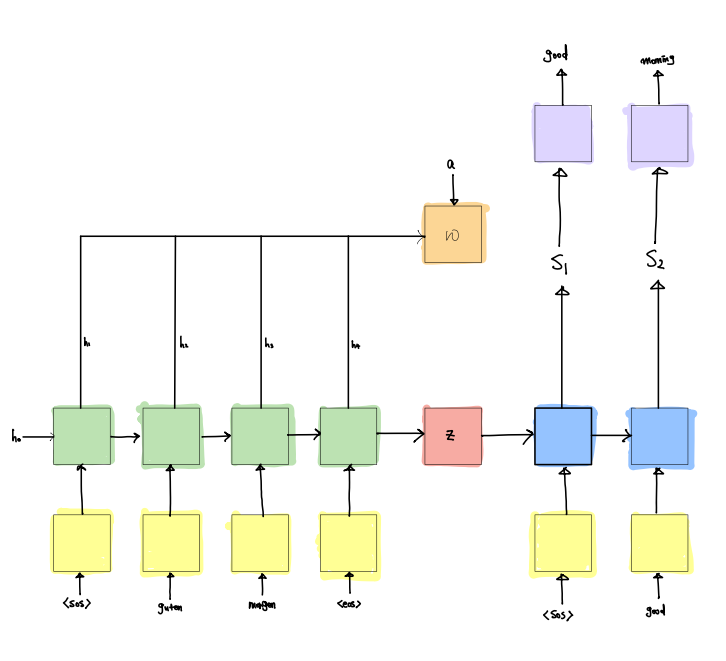